In [1]:
import cv2
import numpy as np
import os
import pandas as pd
import tensorflow as tf
from sklearn import model_selection
from keras.callbacks import EarlyStopping
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report

In [24]:
# global variables

INPUT_SHAPE_X = 128
INPUT_SHAPE_Y = 64
ITERATION = '3'
EPOCHS = 1000
BATCH_SIZE = 20

max_images = 1400 # max images per class

In [3]:
# load labels
csv_path = 'data-labels/labels_preprocessed.csv'
labels = pd.read_csv(csv_path)
# replace NaN values with 0s
labels.fillna(0, inplace=True)

In [4]:
# load the images
whiskers_path = 'data/muzzle'
whiskers_dir = os.listdir(whiskers_path)
x_whiskers = []
y_whiskers = []
i = 0
class_0 = 0
class_1 = 0
class_2 = 0

# iterate over images
for image in whiskers_dir:
    # load the image
    image_path = os.path.join(whiskers_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    
    # preprocess the image
    if (img is not None):
    
        # check image class
        image_class = labels.loc[labels['imageid'] == image, 'whiskers_position']

        if not image_class.empty:
            image_class = image_class.iloc[0]    
            
            # append an equal number of images from each class
            if (image_class == 0.0 and class_0 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_0 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 1.0 and class_1 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_1 += 1
                if (i == max_images*3):
                    break
                i+=1
                
                
            elif (image_class == 2.0 and class_2 < max_images):
                x_whiskers.append(img)
                y_whiskers.append(image_class)
                class_2 += 1
                if (i == max_images*3):
                    break
                i+=1
  


In [5]:
# add flipped images from class 2
flipped_path = 'data/muzzle-flipped'
for image in os.listdir(flipped_path):
    image_path = os.path.join(flipped_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_whiskers.append(img)
    y_whiskers.append(2)
    class_2 += 1

In [6]:
# add augmented images from class 2
aug_path = 'data/muzzle-augmented'
for image in os.listdir(aug_path):
    image_path = os.path.join(aug_path, image)
    img = tf.keras.preprocessing.image.load_img(image_path, target_size=(INPUT_SHAPE_X, INPUT_SHAPE_Y))
    img = tf.keras.preprocessing.image.img_to_array(img)
    x_whiskers.append(img)
    y_whiskers.append(2)
    class_2 += 1

In [7]:
print(class_0, class_1, class_2)

1400 1400 1452


In [8]:
# preprocess
x_whiskers = tf.keras.applications.vgg16.preprocess_input(np.array(x_whiskers))

# split the dataset into train and test sets
x_train_val, x_test, y_train_val, y_test = model_selection.train_test_split(
    x_whiskers, y_whiskers, test_size=0.2, random_state=42)

# split the train and validation sets
x_train, x_val, y_train, y_val = model_selection.train_test_split(
    x_train_val, y_train_val, test_size=0.2, random_state=42)

# one-hot code labels
y_train = tf.one_hot(y_train,3)
y_val = tf.one_hot(y_val,3)
y_test = tf.one_hot(y_test,3)

Metal device set to: Apple M1

systemMemory: 16.00 GB
maxCacheSize: 5.33 GB



2023-04-11 21:22:52.817313: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:305] Could not identify NUMA node of platform GPU ID 0, defaulting to 0. Your kernel may not have been built with NUMA support.
2023-04-11 21:22:52.817669: I tensorflow/core/common_runtime/pluggable_device/pluggable_device_factory.cc:271] Created TensorFlow device (/job:localhost/replica:0/task:0/device:GPU:0 with 0 MB memory) -> physical PluggableDevice (device: 0, name: METAL, pci bus id: <undefined>)


In [25]:
# create the model
model = tf.keras.models.Sequential()
model.add(tf.keras.applications.vgg16.VGG16(weights='weights/vgg16_weights_tf_dim_ordering_tf_kernels_notop.h5', 
                                            include_top=False,
                                            input_shape=(INPUT_SHAPE_X, INPUT_SHAPE_Y, 3)))
model.add(tf.keras.layers.Flatten(input_shape=model.output_shape[1:]))
model.add(tf.keras.layers.Dense(256, activation='relu'))
model.add(tf.keras.layers.Dropout(0.4))
model.add(tf.keras.layers.Dense(128, activation='relu'))
model.add(tf.keras.layers.Dropout(0.2))
model.add(tf.keras.layers.Dense(64, activation='relu'))
model.add(tf.keras.layers.Dense(3, activation='softmax'))

In [26]:
# compile the model
earlystop = EarlyStopping(monitor='val_loss', patience=5)
model.compile(optimizer=tf.keras.optimizers.SGD(learning_rate=1e-3), 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])

In [27]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 4, 2, 512)         14714688  
                                                                 
 flatten_1 (Flatten)         (None, 4096)              0         
                                                                 
 dense_3 (Dense)             (None, 256)               1048832   
                                                                 
 dropout_2 (Dropout)         (None, 256)               0         
                                                                 
 dense_4 (Dense)             (None, 128)               32896     
                                                                 
 dropout_3 (Dropout)         (None, 128)               0         
                                                                 
 dense_5 (Dense)             (None, 64)               

In [28]:
# train the model
hist = model.fit(x_train, y_train, 
              epochs = EPOCHS,
              batch_size = BATCH_SIZE, 
              validation_data = (x_val, y_val),
              callbacks = [earlystop])

Epoch 1/1000


2023-04-11 21:58:29.516703: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


136/136 [==============================] - ETA: 0s - loss: 1.2481 - accuracy: 0.3673

2023-04-11 21:59:00.415783: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


136/136 [==============================] - 35s 248ms/step - loss: 1.2481 - accuracy: 0.3673 - val_loss: 1.0025 - val_accuracy: 0.4141
Epoch 2/1000
136/136 [==============================] - 36s 262ms/step - loss: 1.0248 - accuracy: 0.4118 - val_loss: 0.9964 - val_accuracy: 0.4229
Epoch 3/1000
136/136 [==============================] - 36s 263ms/step - loss: 1.0047 - accuracy: 0.4213 - val_loss: 0.9953 - val_accuracy: 0.4126
Epoch 4/1000
136/136 [==============================] - 36s 263ms/step - loss: 0.9923 - accuracy: 0.4338 - val_loss: 0.9718 - val_accuracy: 0.4214
Epoch 5/1000
136/136 [==============================] - 36s 268ms/step - loss: 0.9820 - accuracy: 0.4412 - val_loss: 0.9680 - val_accuracy: 0.4332
Epoch 6/1000
136/136 [==============================] - 36s 263ms/step - loss: 0.9851 - accuracy: 0.4301 - val_loss: 0.9679 - val_accuracy: 0.4244
Epoch 7/1000
136/136 [==============================] - 35s 257ms/step - loss: 0.9649 - accuracy: 0.4721 - val_loss: 0.9654 - val_a

In [17]:
# save the model and training history
path = 'model-whiskers'
model.save(path)

history_df = pd.DataFrame(hist.history)
path = 'history-whiskers.csv'
history_df.to_csv(path, index=False)

INFO:tensorflow:Assets written to: model-whiskers/assets


INFO:tensorflow:Assets written to: model-whiskers/assets


In [23]:
# evaluate the model
results = model.evaluate(x_test, y_test)
print(results)

27/27 [==============================] - 3s 113ms/step - loss: 2.5399 - accuracy: 0.4677
[2.5398902893066406, 0.4676850736141205]


In [14]:
# make predictions
prob_array = model.predict(x_test)
class_indices = np.argmax(prob_array, axis=1)

# convert the class indices to a one-hot encoded array
class_indices = np.argmax(prob_array, axis=1)
num_classes = 3
y_pred = np.zeros((prob_array.shape[0], num_classes))
y_pred[np.arange(prob_array.shape[0]), class_indices] = 1

 1/27 [>.............................] - ETA: 5s

2023-04-11 21:45:51.037369: I tensorflow/core/grappler/optimizers/custom_graph_optimizer_registry.cc:113] Plugin optimizer for device_type GPU is enabled.


27/27 [==============================] - 3s 102ms/step


In [15]:
# make a classification report

print('\nAccuracy: {:.2f}\n'.format(accuracy_score(y_test, y_pred)))
print('\nClassification Report - whiskers\n')
print(classification_report(y_test, y_pred, target_names=['Score 0', 'Score 1', 'Score 2']))


Accuracy: 0.49


Classification Report - whiskers

              precision    recall  f1-score   support

     Score 0       0.42      0.57      0.49       287
     Score 1       0.44      0.40      0.42       289
     Score 2       0.70      0.51      0.59       275

   micro avg       0.49      0.49      0.49       851
   macro avg       0.52      0.50      0.50       851
weighted avg       0.52      0.49      0.50       851
 samples avg       0.49      0.49      0.49       851



Confusion Matrix

[[164  95  28]
 [140 117  32]
 [ 82  53 140]]


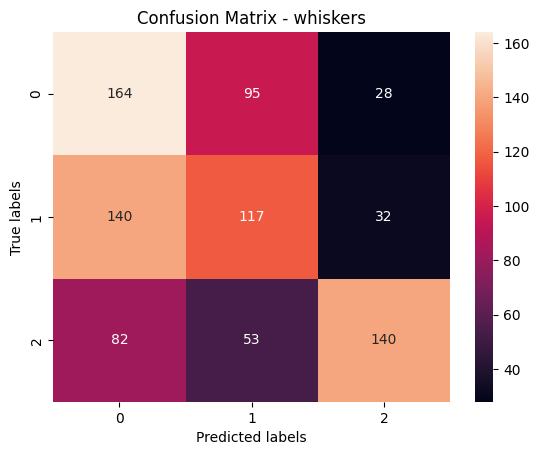

In [16]:
# make a confusion matrix
confusion = confusion_matrix(np.asarray(y_test).argmax(axis=1), np.asarray(y_pred).argmax(axis=1))
print('Confusion Matrix\n')
print(confusion)

lables = ['0','1','2']    
ax= plt.subplot()
sns.heatmap(confusion, annot=True, fmt='g', ax=ax);

# labels, title and ticks
ax.set_xlabel('Predicted labels');ax.set_ylabel('True labels'); 
ax.set_title('Confusion Matrix - whiskers'); 
ax.xaxis.set_ticklabels(lables); ax.yaxis.set_ticklabels(lables);
plt.show()

In [ ]:
!zip -r model_3.zip model_3

  adding: model_3/ (stored 0%)
  adding: model_3/assets/ (stored 0%)
  adding: model_3/keras_metadata.pb (deflated 96%)
  adding: model_3/fingerprint.pb (stored 0%)
  adding: model_3/variables/ (stored 0%)
  adding: model_3/variables/variables.data-00000-of-00001 (deflated 19%)
  adding: model_3/variables/variables.index (deflated 68%)
  adding: model_3/saved_model.pb (deflated 90%)
